# `DETR` : End-to-End Object Detection with Transformers(ECCV 2020)
  - `DE`tection `TR`ansformer
  - Transformer가 핵심 concept으로 사용될 것

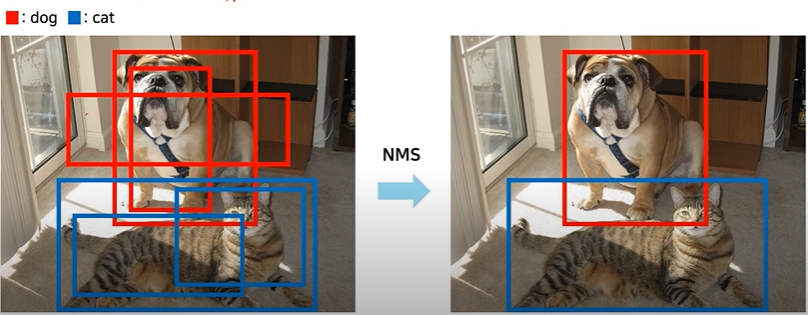

- 기존 객체 탐지
  - 많은 prior knoledge 요구
    - prior knoledge?
      - 이를테면, 탐지를 하고자하는 이미지들이 기차와 같은 긴 형태의 물체들이 많다면 bounding box를 길게 설정하여 탐지하고자 하는 그 대상에 대한 사전 지식을 사용하는 것
      - 이런식으로 bounding box의 형태, 혹은 bounding box가 겹칠 때 처리 방법들을 미리 정의해주어야 했음. 그래야 높은 성능과 각각의 instance들을 성공적으로 분류할 수 있었음
      - 흔히 NMS와 같은 기법이 하나의 이미지가 주어졌을 때 여러 개의 bounding box를 그리고, neural network가 여러 개의 이미지가 존재할법한 그런 위치를 찾아서 각각 다 classification을 진행했다면 중복되는 부분이 많이 생길텐데 이런 것들을 압축을 하여 불필요한 box들은 제거하여 각 instance 마다 한 개의 bounding box만 나올 수 있도록 압축하는 기법을 NMS라 하였음
      - 이런 기법은 bounding box를 어떤 형태로 그릴지, 압축할 때 thresholds나 hyper parameter를 어떤식으로 설정할지 세밀한 조정이 필요했고 이는 복잡한 architecture를 만들었음

$\to$ 간단한 *architecture*가 요구되었음
  - 1) 이분 매칭 함수 이용
    - set prediction problem을 직접적으로 해결
    - 객체를 탐지하는 이슈는 set prediction problem이라 할 수 있음
    - 여기서 set -> 수학적 개념인 `집합`임
      - 중복되는 원소가 없고 순서가 무관한 특성
      - 객체를 탐지함에 있어서 개를 나타내는 bounding box의 위치와 고양이를 나타내는 bounding box의 위치 순서는 상관이 없을 것
      - 즉 이런 특성을 위해 이전에는 NMS등을 이용해 resion proposal을 통해 각각 많이 제안하고 겹치는 거 제거하는 등 이러한 간접적인 일련의 과정이 필요했는데
      - 이런 set prediction problem을 직접적으로 해결할 수 있을까?에 대한 해결책이 됨
      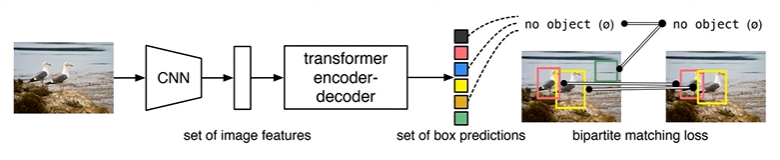
      - set of box predictions 부분에서 전체 나오는 output dimension을 N으로 고정함
        - ? 전체 N개만큼만 이미지에 object instance가 존재할 수 있을 거라 고정한다면, 이제부터는 이분매칭을 통해 직접적으로 해결할 수 있게되는 것
        - ? 무슨 말 ?
          - 예를 들어, 전체 이미지에 6개까지만 object instance가 존재할 수 있다고 가정을 해보자
          - 학습과정에서 이분매칭을 수행함으로써 인스턴스가 중복되지 않도록 유도함 
          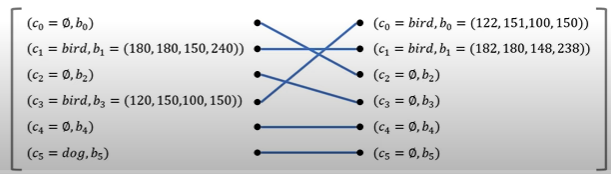
          - 첫번째 예측 결과 : nothing
          - 두번째 예측 결과 : 새가 있으며 $b_1$이라는 위치(중심x,중심y,너비,높이)
          - 세번째 예측 결과 : nothing
          - 네번째 예측 결과 : 새가 있으며 $b_3$이라는 위치(중심x,중심y,너비,높이)
          - 다섯번째 예측결과 : nothing
          - 여섯번째 예측결과 : 개???
            - 이렇게 잘못된 prediction 결과가 있을 때 어떡하지?
            - 그림을 보면 왼쪽 domain쪽은 예측 결과이고 오른쪽 codomain쪽은 실제 값인데
            - 이때, 이분매칭을 수행했을 때 가장 matching이 잘되는 쌍끼리 묶어줌
            - 클래스가 같고 bounding box값이 유사하도록 더 낮은 loss값을 갖도록 일부러 matching loss값을 구성함
            - 그 다음 그 loss값을 다 합쳤을 때, 즉 전체 matching이 끝났을 때 전체 loss값이 줄어드는 방향으로 matching이 진행됨
            - 이렇게 matching loss를 줄어드는 방향으로 이분매칭을 수행한 뒤에 이 상황에서 class가 맞는 것 끼리는 bounding box가 유사해지도록 학습을 수행함
            - 즉 $c_5$처럼 오류가 있으면 자연스럽게 오른쪽 $c_5$로 구분될 수 있도록 학습이 잔행
              - 이런 결과를 내보내는 방향으로 neural network를 학습
    - 핵심***** : set prediction problem에서 이분매칭을 수행하게 되면 예측 결과에서 각각의 순서가 바뀐다하더라도 이분매칭만 잘 된다면 전혀 문제가 없어야함, 순서가 바뀌더라도 문제가 생기지 않아야 함
    - N값을 충분하게 설정해야함
      - 이미지에 존재할 수 있는 instance가 만약 100개라면 더 큰 값인 200정도로 설정해야할 것임
  - 2) transformer architecture를 이용
    - 순차적인 data가 나열돼 있을 때 그 안에 내재된 것들을 학습할 수 있도록 사용할 수 있는 architecture이다.
    - Attention을 통해 전체 이미지의 문맥 정보를 이해
    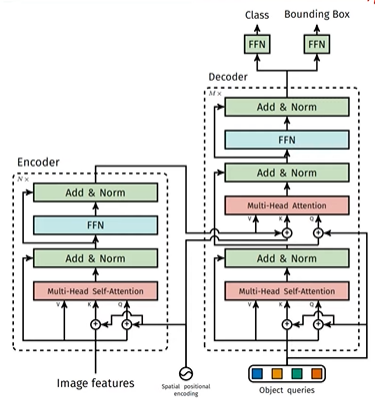
    - 이미지 내 각 instance의 상호작용 파악에 대해 용이하게 해줌
    - Attention을 통해 각 픽셀들이 Attention Score를 매겨서 Attention을 하게 되는데 이 과정을 통해 instance가 분리되고 각 instance들에 대해 상호작용 값들을 파악하게 됨
    - 이를테면 bounding box가 되게 크다면 실제 픽셀 간 거리가 먼 것이기 때문에 long distance에 대한 문제가 발생할 수 있음
      - 흔히 자연어 처리에서도 어떤 문장의 길이가 길다면 즉 단어 사이에서 길이가 멀어지게 되면 앞에 나왔던 단어가 뒤에 나온 단어와의 연관관계 파악이 어려워짐
      - 이런 이슈가 이미지에서도 발생할 수 있다는 것임
      - 이렇게 거리가 먼 픽셀간의 연관성 파악에 있어서도 용이하게 transformer가 적절한 역할을 수행할 수 있음
      - 만약에 bounding box가 크게 만들어졌더라도 해당 box안에서 각각의 거리가 먼 픽셀간끼리도 연관성 파악이 용이하게 됨
    - Transformer Encoder
      - 이미지의 특징 정보를 포함하고 있는 각 픽셀의 위치 데이터를 기반으로 encoding 수행
      - 내부적으로 self attention과 같은 과정을 통해서 이미지의 feature 정보가 들어왔다면 self attention을 수행하면서 각 픽셀에 대한 상호작용, 연관성 정보를 학습할 수 있게 됨
      - 더 상세히
        - 인코더는 d x HW 크기의 연속성을 띄는 feature map을 입력으로 받고 이때 d는 각각의 픽셀에 대한 image feature를 가지고 있는 feature data라 할 수 있고, HW는 각각의 픽셀 위치 정보를 담고 있다. 
        - 인코딩을 다 수행한 뒤에 마지막 layer에서 self-attention map을 시각화해보면 개별 instance를 적절히 분리하는 것을 확인할 수 있다. 
        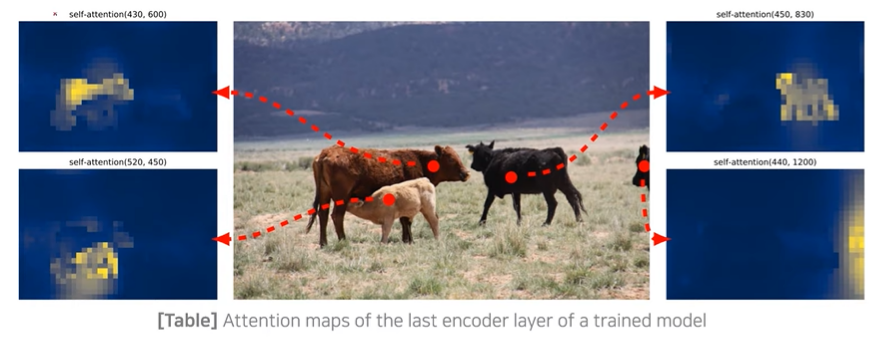
        - 예를 들어 갈색 소에 있는 빨간 점의 픽셀정보에 대한 self-attention값을 확인해보면 즉,이미지에 대해서 어떤 부분에 대해서 많은 연관성을 가지고 있는지를 시각화해보면 갈색 소가 존재하는 위치가 적절하게 attention score가 높게 나옴을 확인할 수 있다.
        - 즉 해당 사진에서 밝은 갈색으로 표시된 부분을 보면 해당 위치에 높은 연관성을 가지고 있다고 모델이 학습한 결과를 확인할 수 있음
    - Transformer Decoder
      - 인코딩된 정보가 실제로 decoding파트에서 사용이 되며, N개의 object query를 초기 입력으로 받음
      - 인코딩된 정보를 받으면서 전체 이미지에 대한 내용을 파악할 수 있게 되고 이런 object query는 일련의 과정을 거쳐 Class와 Bounding Box를 구분할 수 있도록 해줌
      - 즉 N개가 각각 다 N개의 서로 다른 고유한 instance를 구별하도록 해줌
      - 상세히
        - 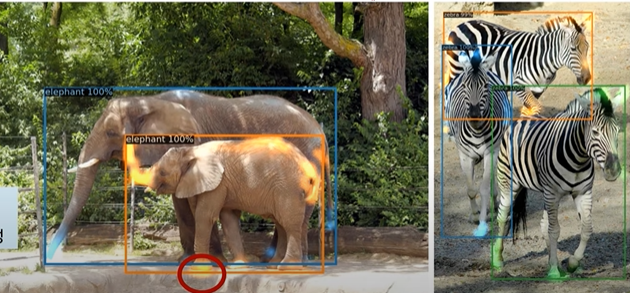
        - 처음에 N개의 object query를 초기 입력으로 이용
        - 인코더가 global attention을 instance를 분리한 뒤에 decoder는 각 instance의 클래스와 경계선을 구별해서 추출하는 기능을 함
          - 논문에서도 언급돼 있는데 실제로 neural network가 동작하는 내용을 인간이 모두 이해하긴 어렵기 때문에 이런식으로 동작을 할거다라고 추측하는 정도임
          - 실제로 decoder 파트에서 각각의 N개의 object에 대해서 attention map을 뽑아보면 instance들이 코끼리라고 나와있는데
          - 좀 더 작은 코끼리의 말단 부분을 보면 attention score값이 높게 형성됨을 확인할 수 있음
          - 말단 부분이 의미하는 것은 각각의 경계선을 잘 구분할 수 있도록 만들어주는 요인이라고 할 수 있음
          - 이렇게 bounding box가 잘 생성될 수 있도록 decoder 파트에서는 학습이 잘 되고 있음을 확인할 수 있음

기본 Architecture
- 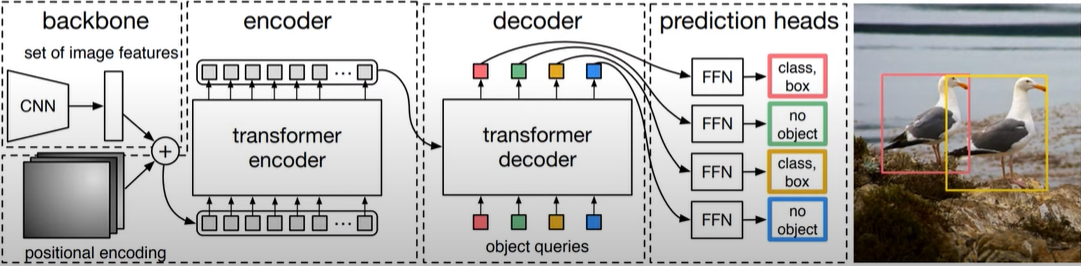

#### **`개괄적 파악`**

> backbone
    
    기본적으로 어떤 이미지에서 feature들을 추출하기 위한 목적으로 해당 네트워크가 사용
    추가적으로 이미지에서 각각의 상대적인 위치 정보를 담기 위해서 positional encoding을 통해 encoder로 data를 보냄 

> encoder

    각각의 픽셀 정보들은 일종의 순차적인 data로 분류가 되어 일련의 data를 처리하기에 적합한 transformer encoder로 삽입됨
    이때 각각의 data들은 특정 dimension을 가지는 이미지 feature로서 구성이 됨
    정리하자면, 각각의 픽셀이 가지고 있는 이미지 feature 정보들이 순차적으로 처리가 되어 encode가 여러 개의 layer를 거쳐 encoding을 수행하고 decoder 파트로 삽입됨
    
> decoder + prediction heads

    몇개의 query를 거쳐 나온 결과가 각각 object에 대한 class와 그 object가 어디 존재하는지 그 bounding box의 위치를 알려줄 수 있도록 분류됨.
    object가 존재하지 않다면 "no object"라고 class가 분류됨

- 이렇게 처음 이미지가 들어왔을 때 그 이미지에 대해서 feature를 추출한 다음에 transformer를 거쳐서 결과적으로 객체 탐지가 가능하게 하는 것이 DETR 모델임
- 이렇게 탐지한 객체 탐지 결과가 실제 값과 비교했을 때 매칭이 성공적으로 이루어질 수 있도록 이분매칭함수까지 사용을 하고 이러한 이분매칭함수를 통해서 중복되지 않은 instance를 각각 탐지할 수 있도록 만들어줌


---

---

---

# **`Summary of Paper`**

> ### `Abstract`
    
    객체 탐지를 direct set prediction problem으로 봄
    즉, 어떠한 각각의 개별적인 instance를 예측해야되는 문제로 상정함
    detection pipeline 자체를 streamline(간소화하다)했음, 즉 간소화했음.
    따라서 NMS도 생략이 가능함
    
    Prior Knowledge도 불필요(앵커의 형태나 bounding box를 어떤 식으로 수정을 할 수 있는지 등의 정보들이 일일히 다 모델링 입장에서 task에 맞게 수정할 필요 없이 데이터만 보고 모델이 자연스럽게 학습할 수 있도록 해줌)
    
    해당 framework에서 가장 중요 => DEtection TRansformation
    -> set-based global loss를 이용함으로써 이분매칭 사용
    -> 이분매칭을 통해 set-based global los들을 이용하고, 따라서 각각의 instance가 겹치지 않고 unique하게 예측이 가능햊해짐
    
    transformer를 이용함으로써 병렬적으로 각각의 prediction 값을 빠르게 구할 수 있음
    
    DETR 같은 경우는 panoptic segmentation에도 활용이 가능할정도로 일반화도 용이하다.

> ### `Introduction`

    객체 탐지 = bounding boxes와 그 category에 대한 하나의 집합을 찾는 게 목적임, 각각의 instance에 대해서 중복되지 않게 판단할 수 있도록 만드는 게 일반적임. 그런데 대부분의 approach들은 indirect way로 접근했음. 즉, 바로 구하지 못하고 있을법한 위치를 많이 찾아보고 regression이나 anchor 혹은 sliding window들을 이용해서 있을법한 것들을 찾고 중복된 것들은 제거하는 과정을 거쳤음
    => set prediction problem을 바로 해결하지 않고 surrogate한 방법으로 해결한다고 볼 수 있음
    => 잘 동작은 했으나, 엄밀히 말하면 data를 통해서 모델을 잘 학습시킬 수 있도록 해야한다는 관점에선 적절하지 못하다고 볼 수 있음
    => 왜? postprocessing이 필요하다는 자체가 사람이 손수 anchor같은 것도 정해주는 과정이 필요하기 때문에 이런 일련의 과정들을 피할 필요가 있음
    => 중복되는 prediction을 피하기 위해 일련의 postprocessing과정이 필요하여 이에 따라 성능이 꽤 좌지우지 됐음
    
    따라서 해당 논문에선 이러한 pipeline을 더욱 간소화하기 위해서 direct set perdiction approach를 적용함
    즉, 이분매칭을 사용하여 이런 이슈들을 바로 해결할 수 있게 해줬음    
    
    아래 그림을 보면, 
    하나의 이미지에 대해 feature를 추출 후, 적당한 flatten을 통해 각각의 sequetial한 정보가 transformer를 거쳐 총 N개의 output을 내보내도록 만들어서 그게 실제 값(gound truth)과 매칭을 통해 중복된 prediction이 나오지 않도록 하는 과정을 거친다.
    
    transformer를 통해 parallel한 연산이 가능
    또한 CNN backbone이 사용됨 -> feature를 추출할 목적임
    
    transformer 파트가 실질적인 object를 분리, 분류하는 역할을 함
    또한 transformer같은 경우는 self-attention mechanism이 사용됨 -> 전반적인 각 instance들의 상호작용 정보를 잘 파악할 수 있도록 만들어주고 각 픽셀별로도 어떤 픽셀과 서로 연관성을 많이 갖고 있는지 이러한 정보도 잘 추출할 수 있도록 만들어줌
    따라서 중복되는 예측 결과를 줄여주는 효과 기대 가능
    (앵커나 NMS, thresholds를 manually 정하는 과정을 줄일 수 있음, 이분매칭 함수를 사용하기 때문에 NMS는 사용하지 않아도 됨)
    
    큰 사이즈의 물체엔 높은 성능을 보이나 상대적으로 작은 사이즈의 물체엔 비교적 낮은 성능을 보임
    
    문제점? 
    학습시간이 상당히 오래걸림

   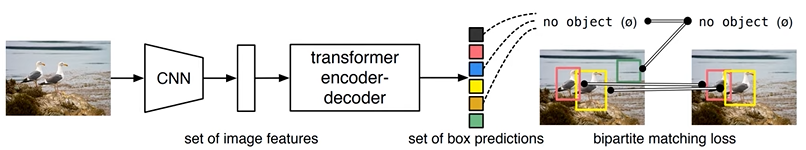

> Related Work

    < Set Prediction >
    direct set prediction을 통해 NMS와 같은 작업 생략 가능
    즉, postprocessing cost 줄일 수 있음
    
    Hungarian algorithm을 통해 이분매칭 수행할 수 있음
    Hungarian algorithm ? 가중치가 있는 이분매칭에 대해 효과적으로 사용할 수 있는 방법임. 이를 통해 loss 값을 최소로 만드는 이분매칭을 찾을 수 있도록 하였음
    
    결론 : set prediction을 위해서 이분매칭을 사용했고, transformer를 이용해서 global inference함에 있어서 좀 더 병렬적으로 빠르게 처리하게 만들었음

> Transformers and Parallel Decoding

    Transformer같은 경우는 Attention을 사용하는데 기본적으로 Attention은 input sequence의 전체 정보를 다 활용하겠다라는 목정이 있다. 
    초기 RNN 같은 경우는 각각의 sequnce들에 포함돼 있는 data들이 순차적으로 처리되어 최종적으로 어떤 context vector를 뽑아낸 다음에 그 결과를 가지고 decoding하는 방식이었음
    Attention 같은 경우는 각각의 과정에 대한 vector또한 활용을 함, decoder파트에서 각각의 sequential한 output data를 attention하도록하여 전체 input sequence에 대한 내용히 활용되도록 만드는 것.
    이런 것들을 좀 더 효과적으로 할 수 있게 만드는 것이 Transformer이다. Attention을 진행함에 있어서 self attention이나 decoder 파트에서 encoder 파트를 attention하는 메커니즘을 같이 사용함으로써 병렬적으로 처리할 수 있도록 제안
    
    따라서 전체 sequnce 파악에 용이, 그런 정보들을 모아서 활용하는 특징

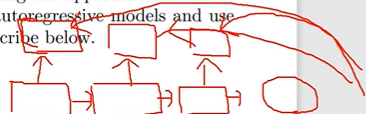

> Object detection

    <Set-basaed loss>
    